<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Константы" data-toc-modified-id="Константы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Константы</a></span></li><li><span><a href="#Функции" data-toc-modified-id="Функции-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Функции</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Гребневая-регрессия" data-toc-modified-id="Гребневая-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Гребневая регрессия</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#Ансамбль-решающих-деревьев-(совет-энтов)" data-toc-modified-id="Ансамбль-решающих-деревьев-(совет-энтов)-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Ансамбль решающих деревьев (совет энтов)</a></span></li><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV,
    GridSearchCV, cross_val_score) 
from sklearn.linear_model import (
    LinearRegression, Ridge)
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict

### Константы

In [ ]:
TEST_SIZE = .2
TEST_SIZE2 = .5
CV = 5
N_JOBS = -1

### Функции

In [ ]:
def make_features(df, max_lag, rolling_size):
    df_f = df.copy()    
    df_f['hour'] = df_f.index.hour
    df_f['day'] = df_f.index.day
    df_f['dayofweek'] = df_f.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_f['lag_{}'.format(lag)] = df_f['num_orders'].shift(lag)

    df_f['rolling_mean'] = df_f['num_orders'].shift().rolling(rolling_size).mean()
    
    return df_f

In [ ]:
def get_sets(df):
    train, pack = train_test_split(df, shuffle=False, test_size=TEST_SIZE)
    val, test = train_test_split(pack, shuffle=False, test_size=TEST_SIZE2)
    train = train.dropna()
    
    print('train', train.index.min(), train.index.max())
    print('val', val.index.min(), val.index.max())
    print('test', test.index.min(), test.index.max())

    train_X = train.drop(['num_orders'], axis=1)
    train_y = train['num_orders']
    val_X = val.drop(['num_orders'], axis=1)
    val_y = val['num_orders'] 
    test_X = test.drop(['num_orders'], axis=1)
    test_y = test['num_orders']
    
    return train_X, train_y, val_X, val_y, test_X, test_y

### Подготовка данных

In [ ]:
try:
    df = pd.read_csv(r'C:\Users\keyten\Desktop\Info\Learning DS\projects\taxi\taxi.csv')
except:
    df = pd.read_csv(r'https://code.s3.yandex.net/datasets/taxi.csv')

In [ ]:
display(df)
df.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [ ]:
df.index = df['datetime']
df = df.drop(['datetime'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.index.is_monotonic

True

<AxesSubplot:title={'center':'График временного ряда до ресемплинга'}, xlabel='datetime'>

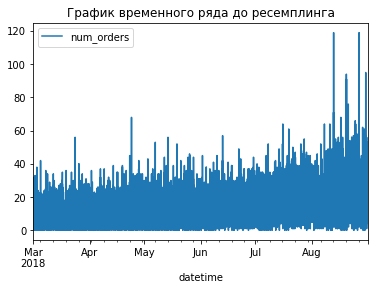

In [ ]:
df.plot(title='График временного ряда до ресемплинга')

<AxesSubplot:title={'center':'График временного ряда после ресемплинга'}, xlabel='datetime'>

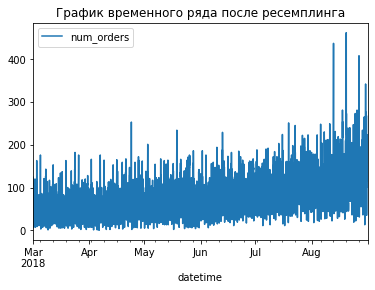

In [ ]:
df = df.resample('1H').sum()
df.plot(title='График временного ряда после ресемплинга')

Дата приведена к формату даты, перемещена в индекс, проверен порядок, проведено ресемплирование по одному дню.

## Анализ

In [ ]:
df_copy = df.copy()

<AxesSubplot:title={'center':'График временного ряда со средним и стандартным отклонением'}, xlabel='datetime'>

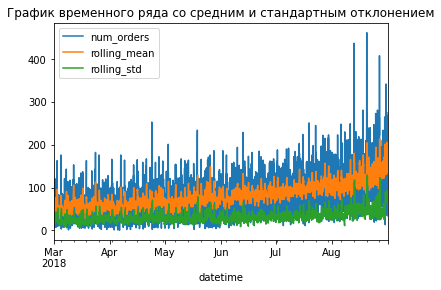

In [ ]:
df_copy['rolling_mean'] = df_copy['num_orders'].rolling(10).mean()
df_copy['rolling_std'] = df_copy['num_orders'].rolling(10).std()

df_copy.plot(title='График временного ряда со средним и стандартным отклонением')

Среднее количество заказов начинает слабый рост в мае, далее в июне и июле наблюдается средний рост, и в августе происходит сильный рост. Стандартное отклонение количества заказов увеличивается в августе.

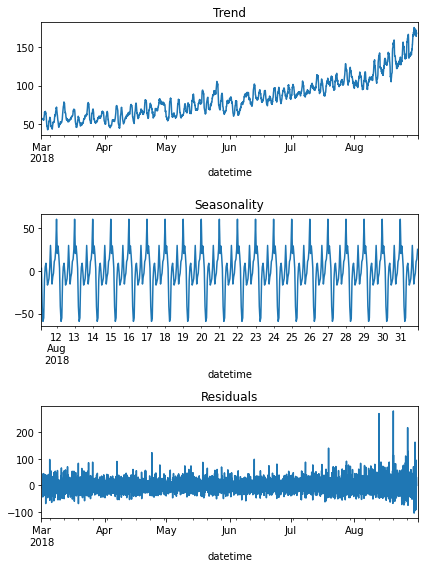

In [ ]:
decomposed = seasonal_decompose(df['num_orders'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal[-500:].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

График тренда подтверждает прошлые выводы.

<AxesSubplot:title={'center':'график разности временного ряда'}, xlabel='datetime'>

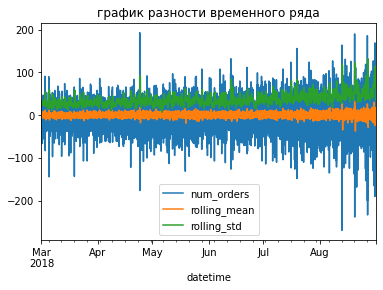

In [ ]:
df_dif = df - df.shift()
df_dif['rolling_mean'] = df_dif['num_orders'].rolling(10).mean()
df_dif['rolling_std'] = df_dif['num_orders'].rolling(10).std()
df_dif.plot(title='график разности временного ряда')

Временной ряд не является стационарным, так как на графике временного ряда явно видны изменения среднего и стандартного отклонения

In [ ]:
import statsmodels.api as sm

In [ ]:
test = sm.tsa.adfuller(df)
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.0689242890279558
p-value:  0.028940051402612906
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


А вот тест Дики-Фуллера утверждает что ряд стационарен, будем верить ему

<AxesSubplot:title={'center':'сезонность сутки'}, xlabel='datetime'>

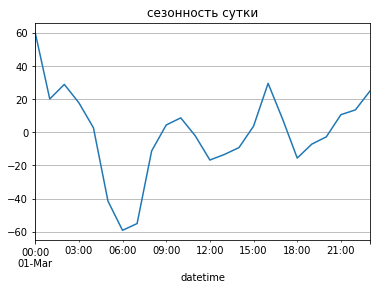

In [ ]:
decomposed.seasonal[:24].plot(grid=True, title='сезонность сутки')

<AxesSubplot:title={'center':'сезонность неделя'}, xlabel='datetime'>

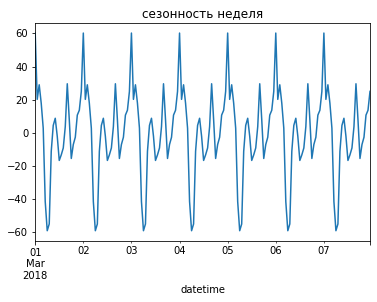

In [ ]:
decomposed.seasonal[:24*7].plot(title='сезонность неделя')

Наблюдается снижение количества заказов такси с полуночи до 6 утра, после чего рост до полуночи с пиками в 16 часов и в полночь. Такая картина повторяется изо дня в день

<div class="alert alert-info">Спасибо</div>

In [ ]:
df_f = make_features(df, 1, 1)

In [ ]:
df_f.describe()

,num_orders,hour,day,dayofweek,lag_1,rolling_mean
count,4416.000000,4416.00000,4416.000000,4416.000000,4415.000000,4415.000000
mean,84.422781,11.50000,15.836957,3.005435,84.395470,84.395470
std,45.023853,6.92297,8.855229,1.990684,44.992356,44.992356
min,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000
25%,54.000000,5.75000,8.000000,1.000000,54.000000,54.000000
50%,78.000000,11.50000,16.000000,3.000000,78.000000,78.000000
75%,107.000000,17.25000,23.250000,5.000000,107.000000,107.000000
max,462.000000,23.00000,31.000000,6.000000,462.000000,462.000000


In [ ]:
df_f[df_f['num_orders'] > 250].sort_index()

,num_orders,hour,day,dayofweek,lag_1,rolling_mean
datetime,,,,,,
2018-04-24 00:00:00,253,0,24,1,60.0,60.0
2018-07-19 10:00:00,251,10,19,3,95.0,95.0
2018-08-13 01:00:00,273,1,13,0,160.0,160.0
2018-08-13 02:00:00,437,2,13,0,273.0,273.0
2018-08-18 00:00:00,281,0,18,5,155.0,155.0
2018-08-18 02:00:00,254,2,18,5,216.0,216.0
2018-08-20 01:00:00,272,1,20,0,200.0,200.0
2018-08-20 02:00:00,462,2,20,0,272.0,272.0
2018-08-20 04:00:00,273,4,20,0,224.0,224.0


Большинство высоких значений приходятся на август, что соответствует тренду.

In [ ]:
df_f['2018-04-23 20:00:00':'2018-04-24 05:00:00']

,num_orders,hour,day,dayofweek,lag_1,rolling_mean
datetime,,,,,,
2018-04-23 20:00:00,53,20,23,0,56.0,56.0
2018-04-23 21:00:00,53,21,23,0,53.0,53.0
2018-04-23 22:00:00,97,22,23,0,53.0,53.0
2018-04-23 23:00:00,60,23,23,0,97.0,97.0
2018-04-24 00:00:00,253,0,24,1,60.0,60.0
2018-04-24 01:00:00,77,1,24,1,253.0,253.0
2018-04-24 02:00:00,83,2,24,1,77.0,77.0
2018-04-24 03:00:00,76,3,24,1,83.0,83.0
2018-04-24 04:00:00,28,4,24,1,76.0,76.0


2018-04-24 00:00:00 похоже на аномалию, но без возможности выяснить у коллег, не стоит принимать поспешных решений. Например это могла прилететь футбольная команда с фанатами, или съемочная группа.

In [ ]:
df_f['2018-07-19 05:00:00':'2018-07-19 15:00:00']

,num_orders,hour,day,dayofweek,lag_1,rolling_mean
datetime,,,,,,
2018-07-19 05:00:00,54,5,19,3,144.0,144.0
2018-07-19 06:00:00,18,6,19,3,54.0,54.0
2018-07-19 07:00:00,33,7,19,3,18.0,18.0
2018-07-19 08:00:00,94,8,19,3,33.0,33.0
2018-07-19 09:00:00,95,9,19,3,94.0,94.0
2018-07-19 10:00:00,251,10,19,3,95.0,95.0
2018-07-19 11:00:00,103,11,19,3,251.0,251.0
2018-07-19 12:00:00,110,12,19,3,103.0,103.0
2018-07-19 13:00:00,57,13,19,3,110.0,110.0


2018-07-19 10:00:00 Также странный резкий скачок, но после него наблюдаются высокие значения постепенно снижающиеся. Не стоит удалять не выяснив причину у коллег, это могла быть отмена рейса к примеру.

In [ ]:
df_f.isna().sum()

num_orders      0
hour            0
day             0
dayofweek       0
lag_1           1
rolling_mean    1
dtype: int64

In [ ]:
df_f.index.is_monotonic

True

## Обучение

### Подготовка

In [ ]:
answers = {'train_RMSE': {}, 'val_RMSE': {}, 'test_RMSE': {}}

In [ ]:
df_f = make_features(df, 50, 1)

In [ ]:
train_X, train_y, val_X, val_y, test_X, test_y = get_sets(df_f)

train 2018-03-03 02:00:00 2018-07-26 03:00:00
val 2018-07-26 04:00:00 2018-08-13 13:00:00
test 2018-08-13 14:00:00 2018-08-31 23:00:00


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

### Линейная регрессия

In [ ]:
model_l = LinearRegression()
model_l.fit(train_X, train_y)
pred_l = model_l.predict(train_X)
print("RMSE train =", mean_squared_error(train_y, pred_l) ** 0.5)
pred_l = model_l.predict(val_X)
print("RMSE val =", mean_squared_error(val_y, pred_l) ** 0.5)

RMSE train = 22.217800633780893
RMSE val = 31.72939587322365


In [ ]:
answers['train_RMSE']['LinearRegression'] = 22.22
answers['val_RMSE']['LinearRegression'] = 31.73

### Гребневая регрессия

In [ ]:
model_r = Ridge()
grid_params = [
    {'solver':[
        'auto',
        'svd',
        'cholesky',
        'lsqr',
        'sparse_cg',
        'sag',
        'saga',
        'lbfgs'], 
     'alpha': [1,0.1,0.01,0.001,0.0001,0], 
     "fit_intercept": [True, False]}]
grid_model_r = GridSearchCV(model_r, 
    grid_params, 
    scoring='neg_mean_squared_error', cv=tscv)
grid_model_r.fit(train_X, train_y)
print('best solver', grid_model_r.best_params_['solver'])
print('best alpha', grid_model_r.best_params_['alpha'])
print('best fit_intercept', grid_model_r.best_params_['fit_intercept'])
print("RMSE =", (grid_model_r.best_score_*-1) ** 0.5)

In [ ]:
grid_model_r_pred = grid_model_r.predict(val_X)
print("RMSE valid =", mean_squared_error(val_y, grid_model_r_pred) ** 0.5)

RMSE valid = 31.57694795207532


In [ ]:
answers['train_RMSE']['Ridge+GridSearchCV'] = 23.54
answers['val_RMSE']['Ridge+GridSearchCV'] = 31.58 

### Градиентный бустинг

In [ ]:
model_c = CatBoostRegressor()
grid_params = {
    'depth': np.arange(4, 11, 1),
    'learning_rate' : [0.01,0.02,0.03,0.04],
    'iterations': np.arange(10, 101, 10)}
grid_model_c = GridSearchCV(model_c, 
    grid_params, 
    scoring='neg_mean_squared_error', cv=tscv)
grid_model_c.fit(train_X, train_y)
print('best depth', grid_model_c.best_params_['depth'])
print('best learning_rate', grid_model_c.best_params_['learning_rate'])
print('best iterations', grid_model_c.best_params_['iterations'])
print("RMSE =", (grid_model_c.best_score_*-1) ** 0.5)

In [ ]:
pred = grid_model_c.predict(val_X)
print("RMSE:", mean_squared_error(val_y, pred) ** 0.5)

RMSE: 34.847442718428496


In [ ]:
answers['train_RMSE']['CatBoostRegressor+GridSearchCV'] = 23.70
answers['val_RMSE']['CatBoostRegressor+GridSearchCV'] = 34.85

In [ ]:
model_c = CatBoostRegressor()
model_c.fit(train_X, train_y)
pred_c = model_c.predict(train_X)
print("RMSE train =", mean_squared_error(train_y, pred_c) ** 0.5)
pred_c = model_c.predict(val_X)
print("RMSE val =", mean_squared_error(val_y, pred_c) ** 0.5)

In [ ]:
answers['train_RMSE']['CatBoostRegressor'] = 8.93
answers['val_RMSE']['CatBoostRegressor'] = 30.77 

### Ансамбль решающих деревьев (совет энтов)

In [ ]:
%%time
model_f = RandomForestRegressor(n_jobs=N_JOBS)
rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 501, step=50),
              'max_features':randint(1,56),              
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }
model_f_random = RandomizedSearchCV(
    model_f, rs_space, n_iter=200, scoring='neg_mean_squared_error', cv=tscv)
model_f_random.fit(train_X, train_y)
print('Best hyperparameters are: '+str(model_f_random.best_params_))
print('Best score is: '+str((model_f_random.best_score_*-1) ** 0.5))

In [ ]:
%%time
model_f = RandomForestRegressor(
    n_jobs=N_JOBS,
    max_features = 30,
    min_samples_leaf = 2,
    min_samples_split = 2,
)
grid_params = [{
    'max_depth': np.arange(25, 35),    
    'n_estimators': np.arange(340, 381, 5)}]
grid_model_f = GridSearchCV(model_f, 
    grid_params, 
    scoring='neg_mean_squared_error', cv=tscv)
grid_model_f.fit(train_X, train_y)
print('Best hyperparameters are: '+str(grid_model_f.best_params_))
print('Best score is: '+str((grid_model_f.best_score_*-1) ** 0.5))

Best hyperparameters are: {'max_depth': 31, 'n_estimators': 355}
Best score is: 22.867895698546715
CPU times: user 55min 31s, sys: 10.1 s, total: 55min 41s
Wall time: 55min 43s


In [ ]:
pred = grid_model_f.predict(val_X)
print("RMSE:", mean_squared_error(val_y, pred) ** 0.5)

RMSE: 32.230735814783756


In [ ]:
answers['train_RMSE']['RandomForestRegressor+RandomizedSearchCV+GridSearchCV'] = 22.85
answers['val_RMSE']['RandomForestRegressor+RandomizedSearchCV+GridSearchCV'] = 32.10 

In [ ]:
answers_df = pd.DataFrame(answers)
answers_df

,train_RMSE,val_RMSE,test_RMSE
LinearRegression,22.22,31.73,NaN
Ridge+GridSearchCV,23.54,31.58,NaN
CatBoostRegressor+GridSearchCV,23.70,34.85,NaN
CatBoostRegressor,8.93,30.77,NaN
RandomForestRegressor+RandomizedSearchCV+GridSearchCV,22.85,32.10,NaN


По результатам на валидационной выборке лучший результат показывает модель CatBoostRegressor "из коробки". 

### Проверка на адекватность

Оценим результаты работы константных моделей

In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
print("Среднее количество заказов в час:", test['num_orders'].mean())


Среднее количество заказов в час: 139.55656108597285


Основанная на медиане

In [ ]:
pred_median = np.ones(test['num_orders'].shape) * train['num_orders'].median()
RMSE = mean_squared_error(test['num_orders'], pred_median)
print("RMSE:", RMSE ** 0.5)

RMSE: 87.15277582981295


Основанная на предыдущем значении 

In [ ]:
pred_previous = test['num_orders'].shift(fill_value=train['num_orders'].iloc[-1])
RMSE = mean_squared_error(test['num_orders'], pred_previous)
print("RMSE:", RMSE ** 0.5)

RMSE: 58.856486242815066


## Тестирование

Проверим модели на тестовой выборке

Линейная модель

In [ ]:
pred = model_l.predict(test_X)
print("RMSE:", mean_squared_error(test_y, pred) ** 0.5)

RMSE: 42.14553461772353


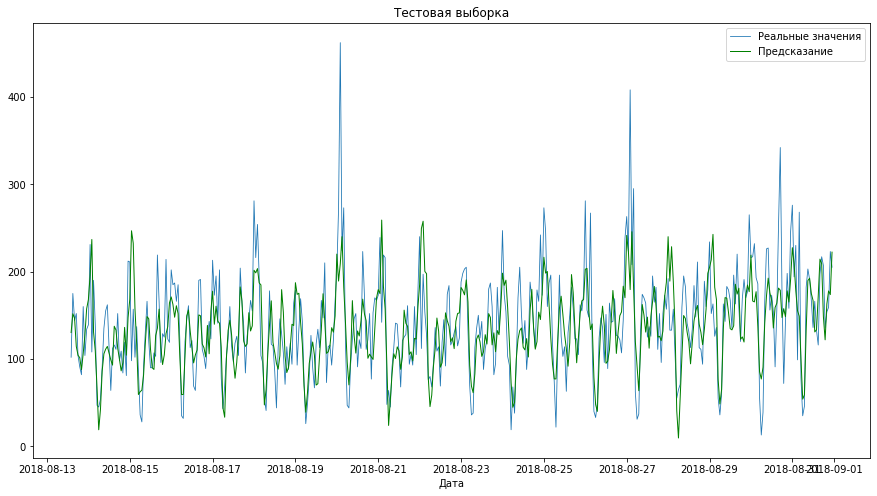

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(test_y.index, test_y, lw=0.8) 
plt.plot(test_y.index, pd.Series(pred, index=test_y.index), color='green', lw=1);
plt.title('Тестовая выборка'); plt.xlabel('Дата'); plt.legend(['Реальные значения', 'Предсказание']);

Гребневая модель 

In [ ]:
pred = grid_model_r.predict(test_X)
print("RMSE:", mean_squared_error(test_y, pred) ** 0.5)

RMSE: 42.02586367018344


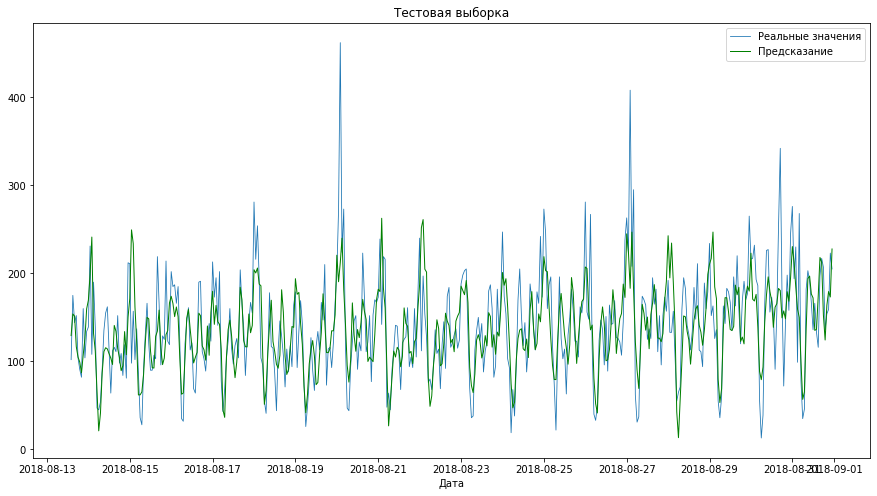

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(test_y.index, test_y, lw=0.8) 
plt.plot(test_y.index, pd.Series(pred, index=test_y.index), color='green', lw=1);
plt.title('Тестовая выборка'); plt.xlabel('Дата'); plt.legend(['Реальные значения', 'Предсказание']);

Градиентный бустинг с поиском гиперпараметров по сетке

In [ ]:
pred = grid_model_c.predict(test_X)
print("RMSE:", mean_squared_error(test_y, pred) ** 0.5)

RMSE: 55.035959927080775


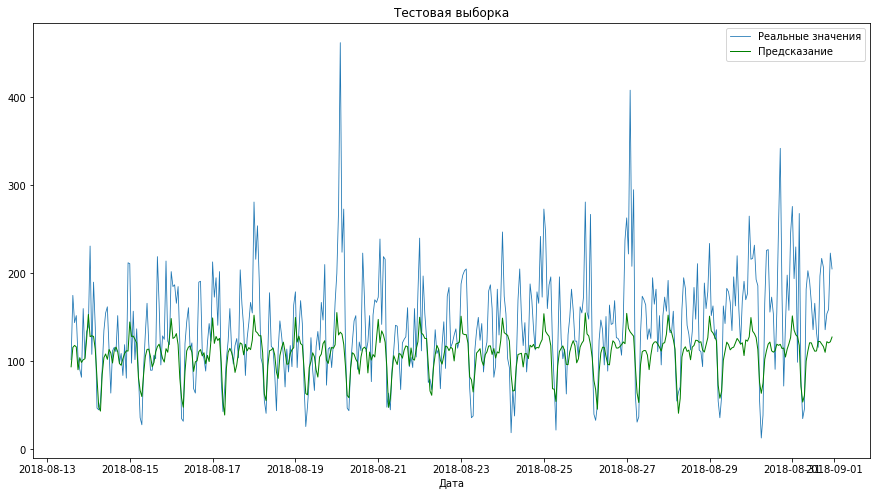

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(test_y.index, test_y, lw=0.8) 
plt.plot(test_y.index, pd.Series(pred, index=test_y.index), color='green', lw=1);
plt.title('Тестовая выборка'); plt.xlabel('Дата'); plt.legend(['Реальные значения', 'Предсказание']);

Градиентный бустинг

In [ ]:
pred = model_c.predict(test_X)
print("RMSE:", mean_squared_error(test_y, pred) ** 0.5)

RMSE: 48.733179037998504


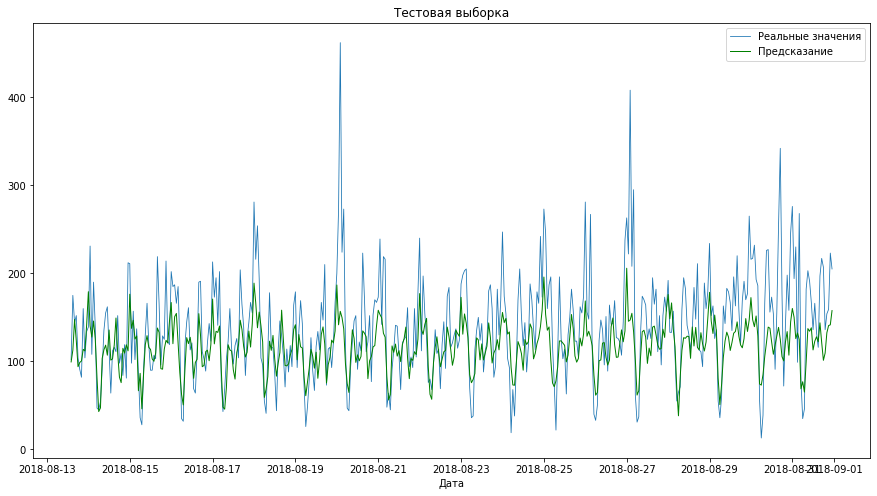

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(test_y.index, test_y, lw=0.8) 
plt.plot(test_y.index, pd.Series(pred, index=test_y.index), color='green', lw=1);
plt.title('Тестовая выборка'); plt.xlabel('Дата'); plt.legend(['Реальные значения', 'Предсказание']);

Решающий лес с поиском гиперпараметров сначала случайным, потом по сетке

In [ ]:
pred = grid_model_f.predict(test_X)
print("RMSE:", mean_squared_error(test_y, pred) ** 0.5)

RMSE: 48.48794573635857


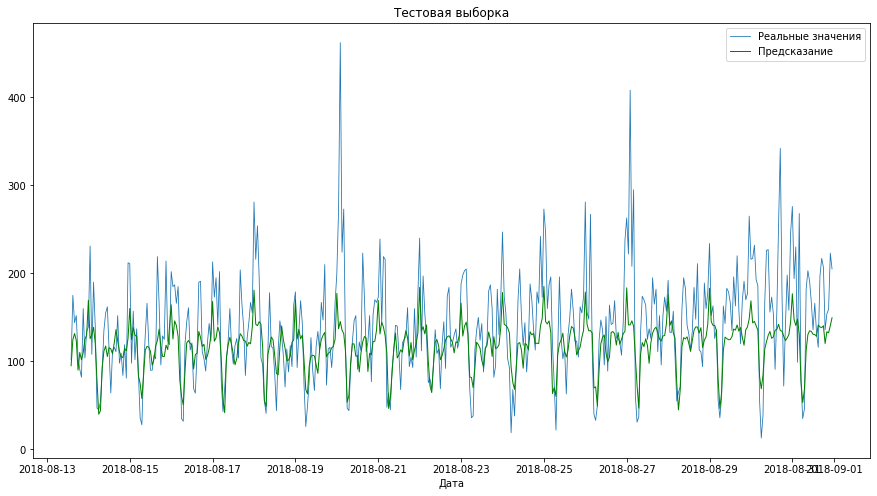

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(test_y.index, test_y, lw=0.8) 
plt.plot(test_y.index, pd.Series(pred, index=test_y.index), color='green', lw=1);
plt.title('Тестовая выборка'); plt.xlabel('Дата'); plt.legend(['Реальные значения', 'Предсказание']);

In [ ]:
answers['test_RMSE']['LinearRegression'] = 42.15 
answers['test_RMSE']['Ridge+GridSearchCV'] = 42.03
answers['test_RMSE']['CatBoostRegressor+GridSearchCV'] = 55.04
answers['test_RMSE']['CatBoostRegressor'] = 48.73
answers['test_RMSE']['RandomForestRegressor+RandomizedSearchCV+GridSearchCV'] = 48.30 

In [ ]:
answers_df = pd.DataFrame(answers)
answers_df

,train_RMSE,val_RMSE,test_RMSE
LinearRegression,22.22,31.73,42.15
Ridge+GridSearchCV,23.54,31.58,42.03
CatBoostRegressor+GridSearchCV,23.70,34.85,55.04
CatBoostRegressor,8.93,30.77,48.73
RandomForestRegressor+RandomizedSearchCV+GridSearchCV,22.85,32.10,48.30


Лучший результат на тестовой выборке показала гребневая регрессия с поиском гиперпараметров по сетке. Хорошо что выбор не пал на градиентный бустинг на основании результатов на валидационной выборке и были проверены все модели.

## Вывод

В ходе работы данные были подготовлены к обучению моделей, осмотрены на присутствие аномалий. Было обучено 6 моделей, проведена проверка на адекватность. В результате сравнения результатов работы моделей была выявлена лучшая. гребневая регрессия с поиском гиперпараметров по сетке показала лучшие результаты, поэтому рекомендуется к рассмотрению в качестве основной рабочей модели машинного обучения для прогнозирования количества заказов такси в будущем.